In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download('stopwords')  # 불용어 리스트 다운로드
nltk.download('punkt')      # 토크나이저 데이터 다운로드
nltk.download('wordnet')    # 표제어 추출(lemmatization)을 위한 WordNet 데이터 다운로드

# 모듈 로딩
# 모델관련 모듈
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
from torchmetrics.classification import F1Score, BinaryF1Score
from torchmetrics.classification import BinaryConfusionMatrix
from torchinfo import summary

from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split








[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KDP-26\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KDP-26\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KDP-26\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
FILE = 'training.1600000.processed.noemoticon.csv'
# ISO-8859-1 또는 latin1 인코딩으로 파일 읽기
df = pd.read_csv(FILE, encoding='ISO-8859-1', header=None)
df.columns = ['sentiment', 'id', 'date', 'flag', 'user', 'text']



df

,sentiment,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [5]:
df.duplicated().sum()

0

In [6]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [7]:
df.isnull().sum()

sentiment    0
id           0
date         0
flag         0
user         0
text         0
dtype: int64

In [8]:
df.isna().sum()

sentiment    0
id           0
date         0
flag         0
user         0
text         0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   sentiment  1600000 non-null  int64 
 1   id         1600000 non-null  int64 
 2   date       1600000 non-null  object
 3   flag       1600000 non-null  object
 4   user       1600000 non-null  object
 5   text       1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [10]:
df = df[['sentiment', 'text']]
df

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


C:\Users\KDP-26\AppData\Local\Temp\ipykernel_10840\3267886552.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='sentiment', palette=[colors[7], colors[9]])


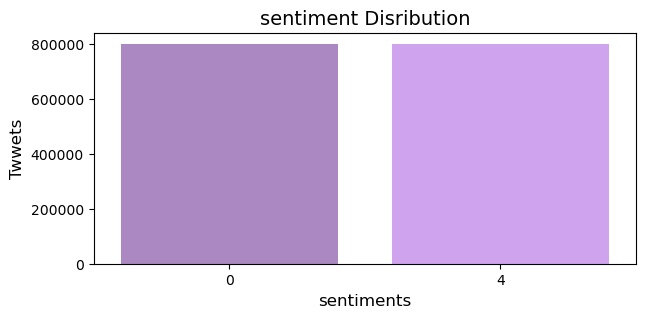

In [11]:
plt.figure(figsize=(7,3))
colors = sns.dark_palette("#d397fa", n_colors=10, input='rgb')
sns.countplot(data=df, x='sentiment', palette=[colors[7], colors[9]])
plt.xlabel("sentiments", size = 12)
plt.ylabel('Twwets', size= 12)
plt.title("sentiment Disribution", size= 14)
plt.show()

In [12]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# 전처리 함수 정의
def preprocess_text(text):
    # 1. 소문자 변환
    text = text.lower()
    
    # 2. URL 제거
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # 3. @, # 기호 제거
    text = re.sub(r'@\w+|#\w+', '', text)
    
    # 4. 불필요한 특수문자 제거 (단어 외의 모든 것 제거)
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # 알파벳과 공백만 남기기
    
    # 5. 불용어 제거
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    # 결과 반환 (전처리된 단어 리스트를 공백으로 연결된 문자열로 반환)
    return ' '.join(words)

# 기존 text 열에 전처리 적용하여 덮어쓰기
df['text'] = df['text'].apply(preprocess_text)

# 'processed_text' 열 제거 (만약 존재한다면)
if 'processed_text' in df.columns:
    df.drop(columns=['processed_text'], inplace=True)

# 전처리된 데이터 확인
df[['text']].head()



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KDP-26\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\KDP-26\AppData\Local\Temp\ipykernel_10840\2970614630.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].apply(preprocess_text)


,text
0,thats bummer shoulda got david carr third day
1,upset cant update facebook texting might cry r...
2,dived many times ball managed save rest go bounds
3,whole body feels itchy like fire
4,behaving im mad cant see


In [13]:
df

,sentiment,text
0,0,thats bummer shoulda got david carr third day
1,0,upset cant update facebook texting might cry r...
2,0,dived many times ball managed save rest go bounds
3,0,whole body feels itchy like fire
4,0,behaving im mad cant see
...,...,...
1599995,4,woke school best feeling ever
1599996,4,thewdbcom cool hear old walt interviews
1599997,4,ready mojo makeover ask details
1599998,4,happy th birthday boo alll time tupac amaru sh...


In [14]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.optim.lr_scheduler as lr_scheduler



In [15]:
# 데이터셋의 10%만 샘플링
df_sampled = df.sample(frac=0.1, random_state=42)

# TF-IDF 벡터화 - 희소 행렬 사용 (max_features=1000으로 줄임)
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = tfidf_vectorizer.fit_transform(df_sampled['text']).toarray()

# 샘플링된 데이터프레임에서 레이블 생성 (0=부정, 4=긍정)
y = df_sampled['sentiment'].apply(lambda x: 1 if x == 4 else 0).values

# 훈련 데이터, 검증 데이터, 테스트 데이터 분할 (80% 학습, 10% 검증, 10% 테스트)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 데이터 크기 확인
print(f'Train: {X_train.shape}, Validation: {X_val.shape}, Test: {X_test.shape}')







Train: (128000, 1000), Validation: (16000, 1000), Test: (16000, 1000)


In [16]:
# 학습에 필요한 하이퍼파라미터 설정
EPOCHS = 30
BATCH_SIZE = 16
LR = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 텐서로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(DEVICE)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(DEVICE)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(DEVICE)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(DEVICE)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(DEVICE)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1).to(DEVICE)

# 데이터셋 및 데이터 로더
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



In [17]:
import torch
import torch.nn as nn

class SentimentClassifier(nn.Module):
    def __init__(self):
        super(SentimentClassifier, self).__init__()
        self.fc1 = nn.Linear(1000, 512)   # 은닉층 1
        self.bn1 = nn.BatchNorm1d(512)    # Batch Normalization 1
        self.fc2 = nn.Linear(512, 256)    # 은닉층 2
        self.bn2 = nn.BatchNorm1d(256)    # Batch Normalization 2
        self.fc3 = nn.Linear(256, 128)    # 은닉층 3
        self.bn3 = nn.BatchNorm1d(128)    # Batch Normalization 3
        self.fc4 = nn.Linear(128, 64)     # 은닉층 4
        self.bn4 = nn.BatchNorm1d(64)     # Batch Normalization 4
        self.fc5 = nn.Linear(64, 1)       # 출력층: 1개의 출력 (이진 분류)
        
        self.relu = nn.ReLU()             # 활성화 함수 (ReLU)
        self.sigmoid = nn.Sigmoid()       # 출력층에서 사용하는 Sigmoid (이진 분류)
        self.dropout = nn.Dropout(p=0.3)  # Dropout (30%)

    def forward(self, x):
        # 입력층 -> 은닉층 1
        x = self.relu(self.fc1(x))
        x = self.bn1(x)                   # Batch Normalization 적용
        x = self.dropout(x)               # Dropout 적용
        
        # 은닉층 1 -> 은닉층 2
        x = self.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout(x)
        
        # 은닉층 2 -> 은닉층 3
        x = self.relu(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout(x)
        
        # 은닉층 3 -> 은닉층 4
        x = self.relu(self.fc4(x))
        x = self.bn4(x)
        x = self.dropout(x)
        
        # 은닉층 4 -> 출력층
        x = self.sigmoid(self.fc5(x))     # Sigmoid 활성화 (이진 분류)
        return x
# 모델, 손실 함수, 옵티마이저 설정
model = SentimentClassifier().to(DEVICE)
criterion = nn.BCELoss()  # 이진 분류용 손실 함수
optimizer = optim.Adam(model.parameters(), lr=LR)

# 학습률 감소 스케줄러
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)


c:\Users\KDP-26\anaconda3\envs\TORCH_38\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [18]:
# Early Stopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=50, min_delta=0.01):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
    
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [19]:
# 학습 및 검증 과정
early_stopping = EarlyStopping(patience=100)

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=EPOCHS):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}")
        
        # 검증
        val_loss = validate_model(model, val_loader)
        
        # Early Stopping 체크
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
        # 학습률 스케줄러 업데이트
        scheduler.step(val_loss)

def validate_model(model, val_loader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    print(f"Validation Loss: {val_loss/len(val_loader)}")
    return val_loss

# 모델 학습
train_model(model, train_loader, val_loader, criterion, optimizer)



Epoch 1/30, Loss: 0.565863282803446
Validation Loss: 0.5287619718611241
Epoch 2/30, Loss: 0.5451189352981746
Validation Loss: 0.522215657427907
Epoch 3/30, Loss: 0.5329879120625556
Validation Loss: 0.5264778125882149
Epoch 4/30, Loss: 0.518757815266028
Validation Loss: 0.5241092036664486
Epoch 5/30, Loss: 0.5030503981858492
Validation Loss: 0.5214412464648486
Epoch 6/30, Loss: 0.48842741865105926
Validation Loss: 0.5253851687610149
Epoch 7/30, Loss: 0.4691704344339669
Validation Loss: 0.5425292472839356
Epoch 8/30, Loss: 0.45437286693789064
Validation Loss: 0.5405723338723183
Epoch 9/30, Loss: 0.4392784185577184
Validation Loss: 0.546006346181035
Epoch 10/30, Loss: 0.42480200111307204
Validation Loss: 0.5657648058831691
Epoch 11/30, Loss: 0.412149619310163
Validation Loss: 0.5845926688313484
Epoch 12/30, Loss: 0.4034840173916891
Validation Loss: 0.5849948257952928
Epoch 13/30, Loss: 0.3939217536626384
Validation Loss: 0.6126078669503331
Epoch 14/30, Loss: 0.3864360020486638
Validation 

In [23]:
# 모델 평가 과정
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs >= 0.5).float()  # 0.5 이상의 값은 긍정으로 분류
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

# 모델 평가
evaluate_model(model, test_loader)


Test Accuracy: 71.89%


In [24]:
# 학습된 모델 저장
torch.save(model.state_dict(), 'model_weights.pth')

# 모델 로드
model = SentimentClassifier()
model.load_state_dict(torch.load('model_weights.pth'))
model.eval()  # 평가 모드


C:\Users\KDP-26\AppData\Local\Temp\ipykernel_10840\1177920183.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weights.pth'))


SentimentClassifier(
  (fc1): Linear(in_features=1000, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (bn3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc4): Linear(in_features=128, out_features=64, bias=True)
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc5): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (dropout): Dropout(p=0.3, inplace=False)
)

In [36]:
import torch
from sklearn.feature_extraction.text import TfidfVectorizer

# 학습된 모델 불러오기
model = SentimentClassifier()  # 동일한 모델 구조
model.load_state_dict(torch.load('model_weights.pth'))  # 저장된 가중치 불러오기
model.eval()  # 평가 모드로 전환

# TF-IDF 벡터화 도구 불러오기
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_vectorizer.fit(df_sampled['text'])  # 기존 데이터로 벡터라이저 학습

def predict_sentiment(model, text, vectorizer, threshold=0.52):
    # 입력된 텍스트를 벡터화 (TF-IDF 또는 다른 벡터화 방식 사용)
    input_vector = vectorizer.transform([text]).toarray()  # 문장을 벡터화
    input_tensor = torch.tensor(input_vector, dtype=torch.float32)  # 텐서로 변환

    # 모델로 예측 수행
    with torch.no_grad():  # 기울기 계산 불필요
        output = model(input_tensor)
        prediction = torch.sigmoid(output)  # 이진 분류이므로 Sigmoid 사용
        predicted_label = (prediction >= threshold).item()  # 0.5 이상이면 긍정

    # 예측 결과 반환 (Positive 또는 Negative)
    return 'Positive' if predicted_label == 1 else 'Negative'

# 사용 예시
text_input = 'i hate you '
result = predict_sentiment(model, text_input, tfidf_vectorizer)
print(f"입력하신 단어나 문장은 {result}입니다.")


C:\Users\KDP-26\AppData\Local\Temp\ipykernel_10840\1828342254.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_weights.pth'))  # 저

입력하신 단어나 문장은 Negative입니다.
